### Documentación

Problemas interesantes para Aprendizaje por refuerzo
 * Gymnasium: https://gymnasium.farama.org/environments/box2d/

## Instalación

!pip install gymnasium  
!pip install gymnasium[box2d] 

## Acciones adicionales

### En macos

pip uninstall swig  
xcode-select -—install (si no se tienen ya)  
pip install swig  / sudo port install swig-python
pip install 'gymnasium[box2d]' # en zsh hay que poner las comillas  

### en Windows

Si da error, se debe a la falta de la versión correcta de Microsoft Visual C++ Build Tools, que es una dependencia de Box2D. Para solucionar este problema, puede seguir los siguientes pasos:  
 * Descargar Microsoft Visual C++ Build Tools desde https://visualstudio.microsoft.com/visual-cpp-build-tools/.
 * Dentro de la app, seleccione la opción "Herramientas de compilación de C++" para instalar.
 * Reinicie su sesión en Jupyter Notebook.
 * Ejecute nuevamente el comando !pip install gymnasium[box2d] en la línea de comandos de su notebook.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import gymnasium.utils.play
import pygame
import time
from gymnasium.wrappers import RecordVideo

from MLP import MLP
from AGLunarLander import AG_Lunar_Lander

%matplotlib inline

## **Human play**

In [13]:
# prueba lunar lander por humano
env = gym.make("LunarLander-v3", render_mode="rgb_array")

lunar_lander_keys = {
    (pygame.K_UP,): 2,
    (pygame.K_LEFT,): 1,
    (pygame.K_RIGHT,): 3,
}
gymnasium.utils.play.play(env, zoom=1.5, keys_to_action=lunar_lander_keys, noop=0)

## **Auto-play**

In [14]:
env = gym.make("LunarLander-v3", render_mode="human")
env_seed = 42
observation, info = env.reset(seed=env_seed)
for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        observation, info = env.reset()
env.close()

----

## **Agent training**

In [4]:
env = gym.make("LunarLander-v3")
architecture = MLP(layers=[8,32,64,32,4])
genetic_algorithm = AG_Lunar_Lander(population_size=100, num_ind_exp=5, MLP=architecture, env=env, env_seed=None)

print("model params:", genetic_algorithm.MLP.size)

start = time.time()
genetic_algorithm.evolve(pmut=0.1, pcross=0.7, ngen=1000, T=6, trace=50, reverse_sort=True, elitism=False)
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo evolución: {int(minutos)} minutos y {segundos:.2f} segundos*******")

best_chromosome = genetic_algorithm.best_global_individual[1]
np.savetxt("results_p1/lunar_lander_AG.txt", best_chromosome)

model params: 4612
Nº gen: 0, Best fitness: -66.19924928707165
Nº gen: 50, Best fitness: -91.37079253691911
Nº gen: 100, Best fitness: -29.032035621889293
Nº gen: 150, Best fitness: -21.079520884013085
Nº gen: 200, Best fitness: -26.804433189802136
Nº gen: 250, Best fitness: -24.510307872334085
Nº gen: 300, Best fitness: 25.95244473835063
Nº gen: 350, Best fitness: -34.507187784886675
Nº gen: 400, Best fitness: -9.936665238983617
Nº gen: 450, Best fitness: -26.006846884887278
Nº gen: 500, Best fitness: -35.623046536090705
Nº gen: 550, Best fitness: -22.453302806265015
Nº gen: 600, Best fitness: -12.07600953082402
Nº gen: 650, Best fitness: -30.920098073363683
Nº gen: 700, Best fitness: 6.438112791469945
Nº gen: 750, Best fitness: -43.71487997898983
Nº gen: 800, Best fitness: -35.90792626968556
Nº gen: 850, Best fitness: -57.762008224857894
Nº gen: 900, Best fitness: -7.663046927149987
Nº gen: 950, Best fitness: -14.87620289780383
Nº gen: 999, Best fitness: -7.5901735535335035
*******Ti

## **Fitnesses evolution**

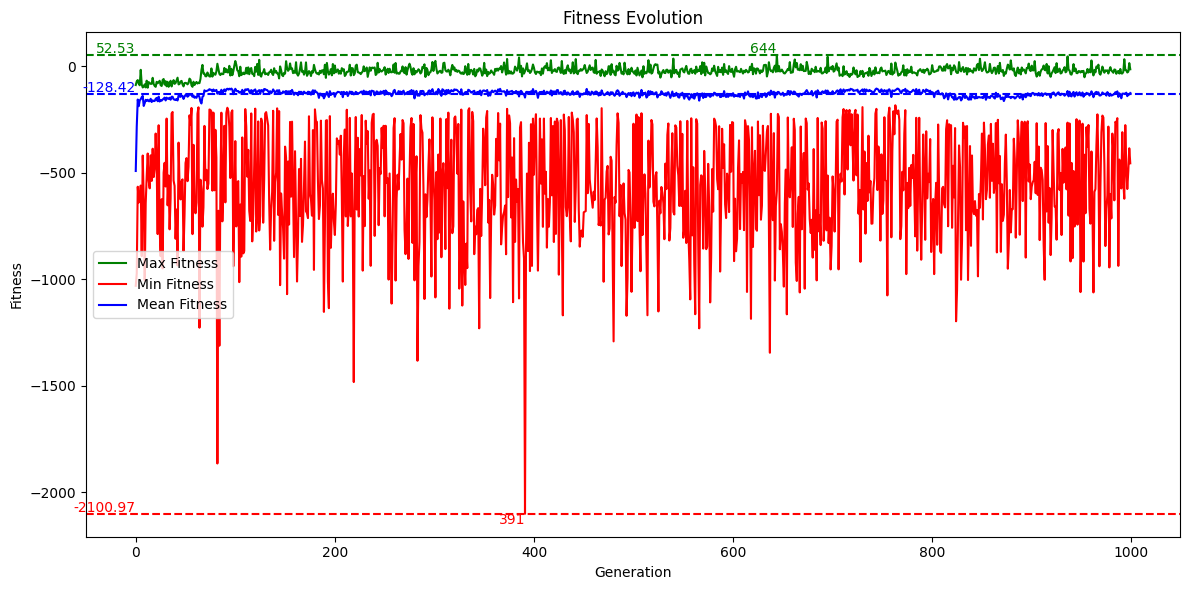

In [10]:
def plot_fitnesses_evolution():
    plt.figure(figsize=(12, 6))
    
    max_fitness = genetic_algorithm.max_fitnesses
    min_fitness = genetic_algorithm.min_fitnesses
    mean_fitness = genetic_algorithm.mean_fitnesses
    
    max_fitness_gen = np.argmax(max_fitness)
    min_fitness_gen = np.argmin(min_fitness)
    
    plt.plot(max_fitness, label='Max Fitness', color='g')
    plt.axhline(y=max(max_fitness), color='g', linestyle='--')
    plt.text(max_fitness_gen, max(max_fitness)+10, f'{max_fitness_gen}', color='g', ha='right')
    plt.text(0, max(max_fitness)+10, f'{max(max_fitness):.2f}', color='g', ha='right') # max value
    
    plt.plot(min_fitness, label='Min Fitness', color='r')
    plt.axhline(y=min(min_fitness), color='r', linestyle='--')
    plt.text(min_fitness_gen, min(min_fitness)-50, f'{min_fitness_gen}', color='r', ha='right')
    plt.text(0, min(min_fitness)+10, f'{min(min_fitness):.2f}', color='r', ha='right') # min value
        
    plt.plot(mean_fitness, label='Mean Fitness', color='b')
    plt.axhline(y=np.mean(mean_fitness), color='b', linestyle='--')
    plt.text(0, np.mean(mean_fitness)+10, f'{np.mean(mean_fitness):.2f}', color='b', ha='right') # mean value
    
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Fitness Evolution')
    plt.legend(loc='center left')
    plt.tight_layout()
    plt.savefig("results_p1/lunar_lander_AG.png")
    plt.show()

plot_fitnesses_evolution()

## **Test best global chromosome**

In [13]:
test_chromosome = np.loadtxt("results_p1/lunar_lander_AG.txt").tolist()
test_model = architecture # previously defined MLP model
test_model.from_chromosome(test_chromosome)

num_episodes_test = 3
destiny_folder = "results_p1/videos"
test_env = gym.make("LunarLander-v3", render_mode="rgb_array")
test_env = RecordVideo(test_env, video_folder=destiny_folder, name_prefix="AG", episode_trigger=lambda x: x < num_episodes_test)  

def policy(observation):
    s = test_model.forward(observation)
    action = np.argmax(s)
    return action

state, _ = test_env.reset()
for episode in range(num_episodes_test):
    done = False
    total_reward = 0
    
    while not done:
        action = policy(state)  
        next_state, reward, done, _, _ = test_env.step(action) 
        total_reward += reward
        state = next_state

        if done:
            print(f"Episode {episode + 1}: Total Reward = {total_reward}")
            state, _ = test_env.reset()
            break  # pasar al siguiente episodio

test_env.close()

Episode 1: Total Reward = -11.526720912945606
Episode 2: Total Reward = -24.22888397866383
Episode 3: Total Reward = 26.4386953509148


## **¿No has tenido bastante?**

Prueba a controlar el flappy bird https://github.com/markub3327/flappy-bird-gymnasium

pip install flappy-bird-gymnasium

import flappy_bird_gymnasium  
env = gym.make("FlappyBird-v0")

Estado (12 variables):
  * the last pipe's horizontal position
  * the last top pipe's vertical position
  * the last bottom pipe's vertical position
  * the next pipe's horizontal position
  * the next top pipe's vertical position
  * he next bottom pipe's vertical position
  * the next next pipe's horizontal position
  * the next next top pipe's vertical position
  * the next next bottom pipe's vertical position
  * player's vertical position
  * player's vertical velocity
  * player's rotation

  Acciones:
  * 0 -> no hacer nada
  * 1 -> volar